In [81]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt # for figures
%matplotlib inline

In [82]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [83]:
len(words)

32033

In [84]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = { ch: i + 1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = { i: ch for ch, i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [85]:
def build_dataset(words):
    # build the dataset
    block_size = 3 # context length: how many characters do we look at at a time to predict the next character
    X, Y = [], []
    for w in words:
        context = [0] * block_size # pad with an extra dot to handle the beginning of the word
        for ch in w + ".": # w + "." adds a period at the end of the word
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


In [86]:
# Split the data into training, validation, and test sets
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_train, Y_train = build_dataset(words[:n1])
X_valid, Y_valid = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [87]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [88]:
C = torch.randn(27, 2) # Lookup Table: 27 characters in the vocab, 2 dimensions
emb = C[X] # look up the embeddings for each character in X
emb.shape
block_size = 3

In [89]:
W1 = torch.randn(2 * block_size, 128) # weights for the first layer
b1 = torch.randn(128) # bias for the first layer

In [90]:
emb.shape

torch.Size([228146, 3, 2])

In [91]:
emb[:, 0, :].shape

torch.Size([228146, 2])

In [92]:
torch.unbind(emb, 1)[0].shape

torch.Size([228146, 2])

In [93]:
torch.cat(torch.unbind(emb, 1), 1).shape   

torch.Size([228146, 6])

In [94]:
a = torch.arange(18)
a.shape

torch.Size([18])

In [95]:
h = torch.tanh(emb.view(-1, 2 * block_size) @ W1 + b1) # first layer of the network

In [96]:
W2 = torch.randn(128, 27) # weights for the second layer
b2 = torch.randn(27) # bias for the second layer
logits = h @ W2 + b2 # second layer of the network
logits.shape

torch.Size([228146, 27])

In [97]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

In [98]:
probs.shape

torch.Size([228146, 27])

In [99]:
Y_train.shape

torch.Size([182625])

In [222]:
# Rewrtie the above code to make it much more respectable xd
g = torch.Generator().manual_seed(2387483647)
C = torch.randn(27, 10, generator=g, requires_grad=True) # Lookup Table: 27 characters in the vocab, 2 dimensions
W1 = torch.randn(10 * block_size, 200, generator=g, requires_grad=True) # weights for the first layer
b1 = torch.randn(200, generator=g, requires_grad=True) # bias for the first layer
W2 = torch.randn(200, 27, generator=g, requires_grad=True) # weights for the second layer
b2 = torch.randn(27, generator=g, requires_grad=True) # bias for the second layer
params = [C, W1, b1, W2, b2]



In [223]:
sum(p.nelement() for p in params)

11897

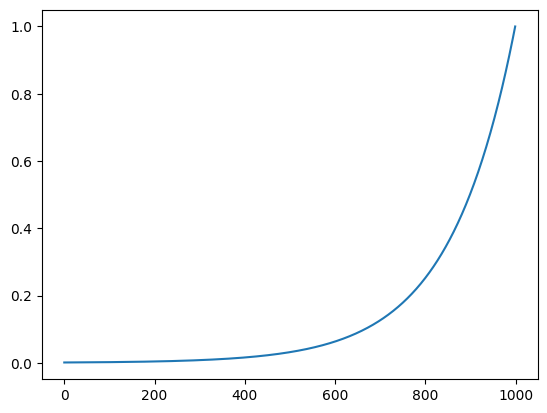

In [224]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10 ** lre # learning rates schedule 
plt.plot(lrs)

In [225]:
lri = []
lossi = []
stepi = []

In [236]:


for i in range(50000):

    # Mini-Batch construct 
    ix = torch.randint(0, X_train.shape[0], (32,)) # Randomly pickup 32 indices from X
    
    # forward pass of the network
    emb = C[X_train[ix]] # look up the embeddings for each character in X
    h = torch.tanh(emb.view(-1, 10 * block_size) @ W1 + b1) # first layer of the network
    logits = h @ W2 + b2 # second layer of the network
    loss = F.cross_entropy(logits, Y_train[ix])
    # print(loss.item())

    # backward pass of the network
    for p in params:
        p.grad = None
    loss.backward()

    # update the weights
    # lr = lrs[i] For the learning rate schedule figuring out the right learning rate
    lr = 0.01
    for p in params:
        p.data += -lr * p.grad

    # track stats to figure out the right learning rate
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())


2.1728479862213135


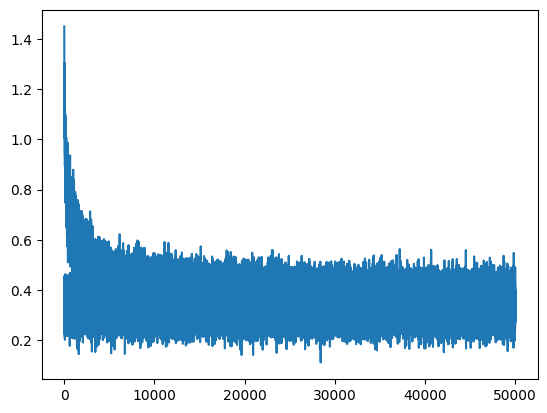

In [237]:
plt.plot(stepi, lossi)

In [238]:
# # plt.plot(lri, lossi)
# plt.plot(lri, lossi)

In [239]:
# Loss over the training set 
emb = C[X_train] # look up the embeddings for each character in X
h = torch.tanh(emb.view(-1, 10 * block_size) @ W1 + b1) # first layer of the network
logits = h @ W2 + b2 # second layer of the network
loss = F.cross_entropy(logits, Y_train)
print(loss)

tensor(2.1636, grad_fn=<NllLossBackward0>)


In [240]:
# Loss over the valid dataset

# forward pass of the network
emb = C[X_valid] # look up the embeddings for each character in X
h = torch.tanh(emb.view(-1, 10 * block_size) @ W1 + b1) # first layer of the network
logits = h @ W2 + b2 # second layer of the network
loss = F.cross_entropy(logits, Y_valid)
print(loss)

tensor(2.1976, grad_fn=<NllLossBackward0>)


In [252]:
# Loss over the validation dataset (Hyperparameter optimization)

# forward pass of the network
emb = C[X_valid] # look up the embeddings for each character in X
h = torch.tanh(emb.view(-1, 10 * block_size) @ W1 + b1) # first layer of the network
logits = h @ W2 + b2 # second layer of the network
loss = F.cross_entropy(logits, Y_valid)
print(loss)


tensor(2.1976, grad_fn=<NllLossBackward0>)


In [251]:
# Loss over the test dataset 

# forward pass of the network
emb = C[X_test] # look up the embeddings for each character in X
h = torch.tanh(emb.view(-1, 10 * block_size) @ W1 + b1) # first layer of the network
logits = h @ W2 + b2 # second layer of the network
loss = F.cross_entropy(logits, Y_test)
print(loss)

tensor(2.1918, grad_fn=<NllLossBackward0>)


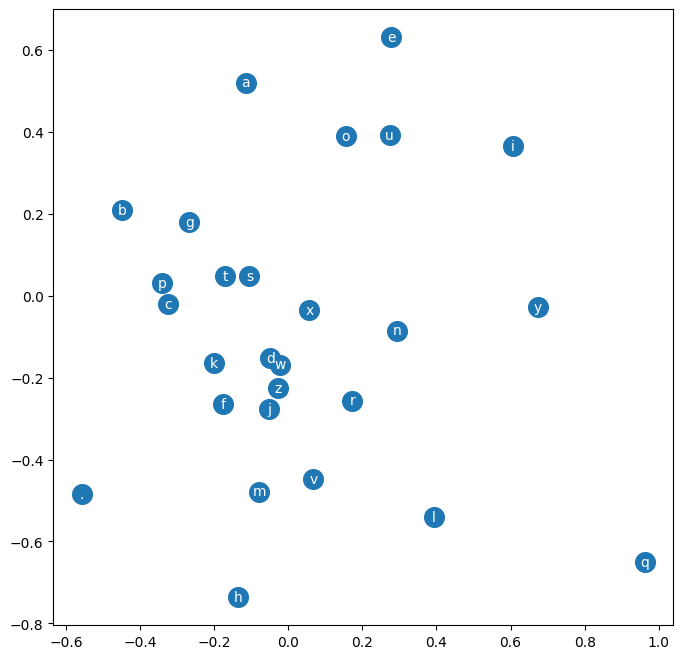

In [213]:
# Visualise the 2-d embedding space 
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')

In [250]:
# Finally Sampling from the model 

for _ in range(20):
    block_size = 3
    out = []
    context = [0] * block_size # Initialize the context with 3 dots
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, 10 * block_size) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, 1).item()
        context = context[1:] + [ix]
        
        if ix == 0:
            break
        out.append(ix)
    
    print(''.join(itos[i] for i in out))

lindayse
rakhaan
eayhoralyn
din
guti
bosh
thalynnix
abd
cael
halai
masshive
luglaya
roskinly
syero
mica
ver
ioulah
nadaleishawri
atsera
amey


10